# Making $$$ with ML:

You've got $1000 to burn. You've decided you want to invest in the stock market, specifically Tesla.
Let's see if we can use Machine Learning to optimize our returns.

Download TSLA.csv from here: https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020/data

Let's get started.

Let's first do some Exploratory Data Analysis (EDA) on the file we've got.

This file is a comma-separated values (CSV) file with 7 columns.

The columns are:
* Date
* Opening price
* Highest price that day
* Lowest price that day
* Closing price
* Adjusted closing price, taking splits etc into account
* Trading volume



In [0]:
# Importing pandas. "pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language."
import pandas as pd 			  		 			 	 	 		 		 	  		   	  			  	
pd.options.display.max_rows = 30
# Read in the CSV, save it to a pandas dataframe variable called 'tsla_data'.
tsla_data = pd.read_csv("TSLA.csv");

In [2]:
# .head() gives us the first 5 rows of the data frame.
# You can also pass .head() a parameter to return any number of rows. Like .head(10) for 10 rows.
tsla_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
# .shape tells us the number of rows, and the number of columns.
# This dataset has 2416 rows, and 7 columns.
# The NYSE and NASDAQ average about 253 trading days a year. 
# This is from 365.25 (days on average per year) * 5/7 (proportion work days per week) - 6 (weekday holidays) - 3*5/7 (fixed date holidays) = 252.75 ≈ 253.
# 10 * 253 = 2530, this dataset is pretty close. Let's assume it's not missing any days.
tsla_data.shape

(2416, 7)

This is 10 years of data, with information about the stock starting from 2010. 

Let's make some assumptions for the sake of time, we're not hedge fund managers yet.

**Assumptions**

*   We can only place one order a day (buy or sell), for the entire amount held.
*   If we place an order, we assume it will go through at that price.
*   We start with $1000

We're going to track a few key pieces of information.

*   Money in wallet
*   Number of stocks held

Let's start with just 2010, to see how much money we would have made if we started with $1000 on the first day of this file. 



In [4]:
# We're going to just pull the 2010 data. I like sticking this in variable, and array, because we'll likely do this again, and by multiple years.
years_to_pull = [2010]

# Let's tell pandas to treat the 'Date' column as a date.
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])

# Let's make a function for re-use
def pull_data_by_year(tsla_data, years_to_pull):
  tsla_data_by_year = tsla_data[tsla_data['Date'].dt.year.isin(years_to_pull)]
  return tsla_data_by_year

tsla_data_by_year = pull_data_by_year(tsla_data, years_to_pull)
tsla_data_by_year.shape

(130, 7)

In [0]:
# Sort by date ASC
tsla_data_by_year = tsla_data_by_year.sort_values(by = 'Date')

Let's add a couple columns to help us with the data. I want to see tomorrow's adjusted close, and I want to know if it's higher than today's adjusted close.

In [6]:
# .shift(-1) brings the next row into the equation, so that we can add a column that shows tomorrow's adjusted close.
tsla_data_by_year["Adj Close Tomorrow"] = tsla_data_by_year["Adj Close"].shift(-1)
# This adds another column as a bool to quickly show if the stock goes up or down tomorrow.
tsla_data_by_year["Stock Goes Up Tomorrow"] = tsla_data_by_year["Adj Close"] < tsla_data_by_year["Adj Close Tomorrow"]
# Let's look at the first 10 rows to see if this looks correct.
tsla_data_by_year.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Stock Goes Up Tomorrow
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,23.830000,False
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,21.959999,False
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,19.200001,False
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,16.110001,False
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,15.800000,False
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,17.459999,True
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,17.400000,False
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600,17.049999,False
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500,18.139999,True
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100,19.840000,True


Following the rule buy low sell high, and we're looking at historical data, we can say the following.

To start pick the first day whose following day's Adj Close price goes up, and buy $1000 worth of shares on that day.

We'll have 3 positions.

Buy
Sell
Hold

In code:

haveNoStock && !goesUpTomorrow = hold

haveNoStock && goesUpTomorrow = buy

haveStock && !goesUpTomorrow = sell

haveStock && goesUpTomorrow = hold


In [7]:
# Setting some default values of the new columns. 
# Position can be Hold/Sell/Buy
tsla_data_by_year['Position'] = 'Hold'
tsla_data_by_year['Number Of Stocks Held'] = 0
tsla_data_by_year['Money In Wallet'] = 0
# .at says at row 0, column 'Money in Wallet', save $1000
tsla_data_by_year.at[0, 'Money In Wallet'] = 1000
tsla_data_by_year.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Stock Goes Up Tomorrow,Position,Number Of Stocks Held,Money In Wallet
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,23.830000,False,Hold,0,1000
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,21.959999,False,Hold,0,0
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,19.200001,False,Hold,0,0
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,16.110001,False,Hold,0,0
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,15.800000,False,Hold,0,0


In [0]:
# Here's my code for determining if I should buy/sell/hold. 
# We'll put this in a function down the line.
previousRow = ''
for index, row in tsla_data_by_year.iterrows():
  if(index > 0):
    row['Money In Wallet'] = previousRow['Money In Wallet']
    row['Number Of Stocks Held'] = previousRow['Number Of Stocks Held']
  if(row['Number Of Stocks Held'] == 0 and not row['Stock Goes Up Tomorrow']):
    row['Position'] = 'Hold'
    # print(1)
  elif(row['Number Of Stocks Held'] == 0 and row['Stock Goes Up Tomorrow']):
    row['Position'] = 'Buy'
    row['Number Of Stocks Held'] = row['Money In Wallet'] / row['Adj Close']
    row['Money In Wallet'] -= row['Number Of Stocks Held'] * row['Adj Close']
    # print(2)
  elif(row['Number Of Stocks Held'] > 0 and not row['Stock Goes Up Tomorrow']):
    row['Position'] = 'Sell'
    row['Money In Wallet'] += row['Number Of Stocks Held'] * row['Adj Close']
    row['Number Of Stocks Held'] = 0
    # print(3)
  elif(row['Number Of Stocks Held'] > 0 and row['Stock Goes Up Tomorrow']):
    row['Position'] = 'Hold'
    # print(4)
  previousRow = row
  tsla_data_by_year.at[index] = row

In [9]:
# Round each number to 2 decimal places.
tsla_data_by_year = tsla_data_by_year.round(2)
# Let's look at the last row to see how much money or stock we have at the end of the year.
tsla_data_by_year.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Stock Goes Up Tomorrow,Position,Number Of Stocks Held,Money In Wallet
129,2010-12-31,26.57,27.25,26.5,26.63,26.63,1417900,NaN,False,Sell,0.0,8645.73


As the end of 2010 we would have $8,645 if we knew the future.


Now let's apply some ML to this. The key here to remember is this is a science, this is an experiment. We need to follow the scientific method.

Our hypothesis: We will attempt to predict if the stock will go up or down tomorrow. 

When we are trying to predict two possible outcomes it is called **Binary Classification.**

The goal is for a given row we can predict the column that tells us if the stock will go up tomorrow, but all we have are today's highs/lows and prices. That doesn't give us much information, we need to try and trend out historical prices. For this we use technical indicators. 



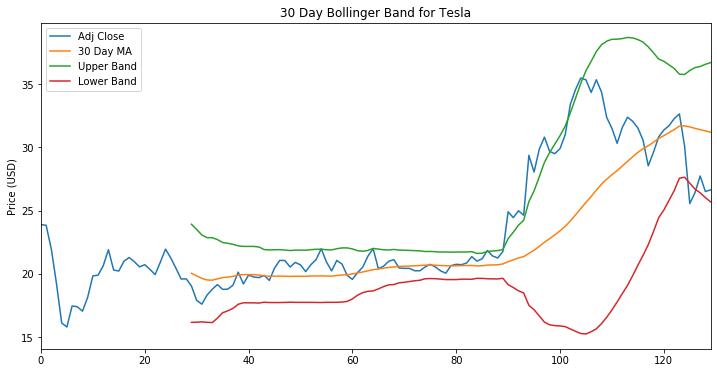

In [10]:
## Add bollinger bands
## To learn more about bollinger bands: https://www.investopedia.com/terms/b/bollingerbands.asp
import matplotlib.pyplot as plt

tsla_data_by_year['30 Day MA'] = tsla_data_by_year['Adj Close'].rolling(window=30).mean()
tsla_data_by_year['30 Day STD'] = tsla_data_by_year['Adj Close'].rolling(window=30).std() 

tsla_data_by_year['Upper Band'] = tsla_data_by_year['30 Day MA'] + (tsla_data_by_year['30 Day STD'] * 2)
tsla_data_by_year['Lower Band'] = tsla_data_by_year['30 Day MA'] - (tsla_data_by_year['30 Day STD'] * 2)

# Simple 30 Day Bollinger Band for Tesla (2016-2017)
tsla_data_by_year[['Adj Close', '30 Day MA', 'Upper Band', 'Lower Band']].plot(figsize=(12,6))
plt.title('30 Day Bollinger Band for Tesla')
plt.ylabel('Price (USD)')
plt.show();

# This plot will show us the adjusted close, the rolling average, and the upper and lower bands of the TSLA stock.

In [11]:
# Since we used a 30 day moving average, the starting 30 days do not have bollinger bands information.
# We use dropna() to drop the nulls.
tsla_data_by_year = tsla_data_by_year.dropna()
tsla_data_by_year.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tomorrow,Stock Goes Up Tomorrow,Position,Number Of Stocks Held,Money In Wallet,30 Day MA,30 Day STD,Upper Band,Lower Band
29,2010-08-10,19.65,19.65,18.82,19.03,19.03,1281300,17.90,False,Hold,0.00,1660.38,20.041333,1.937226,23.915786,16.166880
30,2010-08-11,18.69,18.88,17.85,17.90,17.90,797600,17.60,False,Hold,0.00,1660.38,19.841667,1.832744,23.507156,16.176178
31,2010-08-12,17.80,17.90,17.39,17.60,17.60,691000,18.32,True,Buy,94.34,0.00,19.634000,1.714383,23.062765,16.205235
32,2010-08-13,18.18,18.45,17.66,18.32,18.32,634000,18.78,True,Hold,94.34,0.00,19.512667,1.672380,22.857427,16.167907
33,2010-08-16,18.45,18.80,18.26,18.78,18.78,485800,19.15,True,Hold,94.34,0.00,19.498667,1.676840,22.852346,16.144987


In [0]:
# Some fantastical python. 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import numpy as np
from matplotlib import pyplot, dates

# Here we are saying we want to predict the column 'Stock Goes Up Tomorrow' by storing the column name in a variable.
predict = 'Stock Goes Up Tomorrow'
X = tsla_data_by_year
# Treat the date as a number
X['Date'] = X['Date'].dt.strftime('%Y%m%d')

# For each column, apply a LabelEncoder. Regression problems need numerical values or categorical values. 
# With columns like 'Position', we need to apply a LabelEncoding to set 1 = Hold, 2 = Buy, 3 = Sell (this is an example, the LabelEncoder will determine the numerical values of the categories at runtime.)
for column in X.columns:
  if column != 'Date':
    if X[column].dtype == type(object):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])

# Set the y dataset to just the single column we want to predict.
y = tsla_data_by_year[predict]

# Set the X dataset (what we will use to predict), to all the columns mentioned.
X = tsla_data_by_year[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '30 Day MA', '30 Day STD', 'Upper Band', 'Lower Band']]

# This is used to stratify. Learn more here: https://en.wikipedia.org/wiki/Stratified_sampling
targets = tsla_data_by_year[predict]

# This splits the dataset into training and testing. 60% of the data will be used to train, 40% will be used to test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=101, stratify=targets)

In [13]:
X_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band
65,20100930,22.00,22.15,20.19,20.41,20.41,2195800,20.382333,0.786847,21.956028,18.808639
106,20101129,35.41,35.95,33.33,34.33,34.33,1145600,26.106333,5.340324,36.786982,15.425684
57,20100920,20.67,21.35,20.16,21.06,21.06,947500,19.866667,1.058318,21.983302,17.750031
99,20101117,30.20,30.75,28.61,29.49,29.49,750000,23.079667,3.586195,30.252057,15.907276
90,20101104,22.60,25.33,22.15,24.90,24.90,1874000,20.957667,0.907603,22.772872,19.142461


In [0]:
from sklearn import ensemble

# hyper parameters for the GradientBoostingRegressor algorithm.. More on this much later.
params = {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

# Fit the classifier with the training data.
clf.fit(X_train, y_train)

# Use the trained model to predict the testing dataset.
y_pred_original = clf.predict(X_test)

In [15]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score, classification_report)
y_pred = y_pred_original > .5
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred * 1
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# The confusion matrix will show us True/False Positives, True/False Negatives.
# This dataset is really small to get an accurate reading of the score, but so far it looks like we're close to 50% accurate.

[[12  7]
 [14  7]]
              precision    recall  f1-score   support

       False       0.46      0.63      0.53        19
        True       0.50      0.33      0.40        21

    accuracy                           0.48        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.48      0.47      0.46        40



We're slightly worse than a coinflip! Let's see how this works.

In [16]:
predictions = clf.predict(X)
# The values of predictions are stored as a value from 0.00 to 1.00, but we need them as a true/false to work with our algorithm to calculate $$. Here I compare to .5 (threshold) to determine if the prediction is true or false.
# You can manually adjust the threshold to get a better True Positive / True Negative rate, sometimes it's beneficial if they're trying to reduce a particular metric.
predictions = predictions > .5
X['Stock Goes Up Tomorrow'] = predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Same code as above, functionized. Use a dataset to determine how much money we'll have made with our trades.
def howMuchMoneyDidWeMake(X):
  if('Money In Wallet' not in X ):
    X['Position'] = 'Hold'
    X['Number Of Stocks Held'] = 0
    X['Money In Wallet'] = 0
    X.at[0, 'Money In Wallet'] = 1000
  
  previousRow = ''
  for index, row in X.iterrows():
    # print(row)
    if(index > 0):
      row['Money In Wallet'] = previousRow['Money In Wallet']
      row['Number Of Stocks Held'] = previousRow['Number Of Stocks Held']
    if(row['Number Of Stocks Held'] == 0 and not row['Stock Goes Up Tomorrow']):
      row['Position'] = 'Hold'
      # print(1)
    elif(row['Number Of Stocks Held'] == 0 and row['Stock Goes Up Tomorrow']):
      row['Position'] = 'Buy'
      row['Number Of Stocks Held'] = row['Money In Wallet'] / row['Adj Close']
      row['Money In Wallet'] -= row['Number Of Stocks Held'] * row['Adj Close']
      # print(2)
    elif(row['Number Of Stocks Held'] > 0 and not row['Stock Goes Up Tomorrow']):
      row['Position'] = 'Sell'
      row['Money In Wallet'] += row['Number Of Stocks Held'] * row['Adj Close']
      row['Number Of Stocks Held'] = 0
      # print(3)
    elif(row['Number Of Stocks Held'] > 0 and row['Stock Goes Up Tomorrow']):
      row['Position'] = 'Hold'
      # print(4)
    previousRow = row
    X.at[index] = row
    X = X.round(2)

  return X

In [18]:
X = X.reset_index()
X = howMuchMoneyDidWeMake(X)
X.tail(1)

,index,Date,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,Stock Goes Up Tomorrow,Position,Number Of Stocks Held,Money In Wallet
99,128,20101230,27.7,27.9,26.38,26.5,26.5,2041100,31.28,2.63,36.55,26.02,False,Hold,0.0,2917.96


Not bad! We almost tripled our money. We end up with $2917.

But there is a rookie mistake here. We're measuring our success with the same data we used to train the algorithm. We need another dataset to test this against. Let's pull the next year and try again.

---



In [19]:
# Let's pull 2011 data.
years_to_pull = [2011]
tsla_data_by_year = pull_data_by_year(tsla_data, years_to_pull)

def addBollingerBands(df):
  df['30 Day MA'] = df['Adj Close'].rolling(window=30).mean()
  df['30 Day STD'] = df['Adj Close'].rolling(window=30).std() 
  df['Upper Band'] = df['30 Day MA'] + (df['30 Day STD'] * 2)
  df['Lower Band'] = df['30 Day MA'] - (df['30 Day STD'] * 2)
  df = df.dropna()
  return df

tsla_data_by_year = addBollingerBands(tsla_data_by_year)
tsla_data_by_year.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,Date,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band
159,2011-02-14,23.639999,24.139999,23.049999,23.08,23.08,1283100,24.937333,1.720240,28.377814,21.496853
160,2011-02-15,23.010000,23.170000,22.559999,22.84,22.84,953700,24.811333,1.731142,28.273617,21.349049
161,2011-02-16,23.100000,24.969999,23.070000,24.73,24.73,4115100,24.746667,1.695178,28.137023,21.356310
162,2011-02-17,24.629999,25.490000,23.549999,23.60,23.60,2618400,24.639000,1.660516,27.960031,21.317969
163,2011-02-18,23.330000,23.490000,22.959999,23.18,23.18,2370700,24.482333,1.563047,27.608427,21.356240


In [20]:
# Function to add the predicted column to a dataset using a trained classifier
def addPredictedColumn(df, clf):
  df['Date'] = df['Date'].dt.strftime('%Y%m%d')
  # df["Adj Close Tomorrow"] = df["Adj Close"].shift(-1)

  df = df.dropna()

  for column in df.columns:
    if column != 'Date':
      if df[column].dtype == type(object):
          le = LabelEncoder()
          df[column] = le.fit_transform(df[column])
  

  predictions = clf.predict(df)
  predictions = predictions > .5
  df['Stock Goes Up Tomorrow'] = predictions
  return df

tsla_data_by_year = addPredictedColumn(tsla_data_by_year, clf)
tsla_data_by_year = tsla_data_by_year.reset_index()
tsla_data_by_year = howMuchMoneyDidWeMake(tsla_data_by_year)
tsla_data_by_year.tail(1)

,index,Date,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,Stock Goes Up Tomorrow,Position,Number Of Stocks Held,Money In Wallet
222,381,20111230,28.49,28.98,28.25,28.56,28.56,339800,30.66,2.33,35.33,25.99,False,Hold,0.0,1652.3


If we run a model trained in 2010 against data in 2011, we end up with a total of $1652.01. That's pretty bad. I think the issue is we're not taking into account new data about TSLA in 2011, we're simply using 2010 to predict 2011. That won't do. 

What if we re-train the model every 30 days in 2011? That way the classifer 'resets' every 30 days to any new patterns discovered.

In [21]:
existing_df = tsla_data_by_year
years_to_pull = [2011]
tsla_data_by_year = pull_data_by_year(tsla_data, years_to_pull)
tsla_data_by_year = addBollingerBands(tsla_data_by_year)
tsla_data_by_year = tsla_data_by_year.reset_index()
working_df = tsla_data_by_year[:30]
working_df = working_df.drop(columns=['index'])
working_df = addPredictedColumn(working_df, clf)
working_df = howMuchMoneyDidWeMake(working_df)

all_the_money = pd.concat([working_df], sort=True)
        
for i in range(1, 8):
  new_first_row = working_df[-1:]
  for column in working_df.columns:
    if column != 'Date':
      if working_df[column].dtype == type(object):
          le = LabelEncoder()
          working_df[column] = le.fit_transform(working_df[column])
  existing_df = pd.concat([existing_df, working_df], sort=True)
  working_df = tsla_data_by_year[30*i:30*i+30]
  existing_df["Adj Close Tomorrow"] = existing_df["Adj Close"].shift(-1)
  existing_df = existing_df.dropna()
  existing_df["Stock Goes Up Tomorrow"] = existing_df["Adj Close"] < existing_df["Adj Close Tomorrow"]
  predict = 'Stock Goes Up Tomorrow'
  X = existing_df
  for column in X.columns:
    if column != 'Date':
      if X[column].dtype == type(object):
          le = LabelEncoder()
          X[column] = le.fit_transform(X[column])

  y = existing_df[predict]
  X = existing_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
        '30 Day MA', '30 Day STD', 'Upper Band', 'Lower Band']]
  targets = existing_df[predict]
  params = {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 3,
            'learning_rate': 0.01, 'loss': 'ls'}
  clf = ensemble.GradientBoostingRegressor(**params)
  clf.fit(X, y)
  working_df = working_df.drop(columns=['index'])
  working_df = addPredictedColumn(working_df, clf)
  working_df = pd.concat([new_first_row, working_df], sort=True)
  working_df = working_df.reset_index(drop=True)
  working_df = howMuchMoneyDidWeMake(working_df)
  all_the_money = pd.concat([all_the_money, working_df], sort=True)

all_the_money.tail(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,30 Day MA,30 Day STD,Adj Close,Close,Date,High,Low,Lower Band,Money In Wallet,Number Of Stocks Held,Open,Position,Stock Goes Up Tomorrow,Upper Band,Volume
13,30.66,2.33,28.56,28.56,20111230,28.98,28.25,25.99,0.0,322.57,28.49,Buy,True,35.33,339800


Retraining the model every 30 days in 2011 we end up with 322 shares at \$28.56, that amounts to $9,196.

That's pretty good!

Brb calling my broker..